In [8]:
# !pip install matplotlib
# ! pip install torch==2.0.0 
# !pip install torchvision==0.15.1
# !pip install d2l==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 50.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 71.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 84.9 MB/s eta 0:00:00 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.9/28.9 MB 75.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.4/257.4 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 81.0 MB/s eta 0:00:00a 0:00:01

## Prelims


In [30]:
import time
import numpy as np
import random
import torch
from torch import nn
from d2l import torch as d2ltorch

def add_to_class(Class):  #@save
    """Register functions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

class HyperParameters:  #@save
    """The base class of hyperparameters."""
    def save_hyperparameters(self, ignore=[]):
        raise NotImplemented

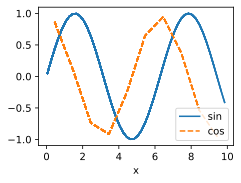

In [32]:
class ProgressBoard(d2ltorch.HyperParameters):  #@save
    """The board that plots data points in animation."""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()
    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

board = d2ltorch.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)

In [33]:
class Module(nn.Module, d2ltorch.HyperParameters):  #@save
    """The base class of models."""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()
    def loss(self, y_hat, y):
        raise NotImplementedError
    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)
    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.to(d2ltorch.cpu()).detach().numpy(),('train_' if train else 'val_') + key, every_n=int(n))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l
    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)
    def configure_optimizers(self):
        raise NotImplementedError


class DataModule(d2ltorch.HyperParameters):  #@save
    """The base class of data."""
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()
    def get_dataloader(self, train):
        raise NotImplementedError
    def train_dataloader(self):
        return self.get_dataloader(train=True)
    def val_dataloader(self):
        return self.get_dataloader(train=False)

class Trainer(d2ltorch.HyperParameters):  #@save
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'
    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)
    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model
    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
    def fit_epoch(self):
        raise NotImplementedError


In [36]:
class SyntheticRegressionData(d2ltorch.DataModule):  #@save
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise

data = SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)

print('features:', data.X[0],'\nlabel:', data.y[0])


@d2ltorch.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        # The examples are read in random order
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))
    for i in range(0, len(indices), self.batch_size):
        batch_indices = torch.tensor(indices[i: i+self.batch_size])
        yield self.X[batch_indices], self.y[batch_indices]

X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

@d2ltorch .add_to_class(d2ltorch.DataModule)  #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size,
                                       shuffle=train)
@d2ltorch.add_to_class(SyntheticRegressionData)  #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)
len(data.train_dataloader())

features: tensor([-0.0076, -1.3918]) 
label: tensor([8.9045])
X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])
X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


32

## Linear Regression form Scratch

In [9]:
%matplotlib inline
import torch
from d2l import torch as d2ltorch

In [37]:
class LinearRegressionScratch(d2ltorch.Module):
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True) # getting values form a Normal distribution with mu=0, sigma=0.01
        self.b = torch.zeros(1, requires_grad=True)

@d2ltorch.add_to_class(LinearRegressionScratch)
def forward(self, X):
    return torch.matmul(X, self.w) + self.b


In [46]:
@d2ltorch.add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
    l = (y_hat-y)**2/2
    return l.mean()


In [48]:
class SGD(d2ltorch.HyperParameters):
    """Minibatch stochastic gradient descent"""
    def __init__(self, params, lr):
        self.save_hyperparameters()
    
    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_() # set all the gradients to zero, whihch should ne run before a backpropagation step(otherewise it will add to the prev gradient and the value will be very small)


In [44]:
@d2ltorch.add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

In [41]:
@d2ltorch.add_to_class(d2ltorch.Trainer)
def prepare_batch(self, batch):
    return batch

@d2ltorch.add_to_class(d2ltorch.Trainer)
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1


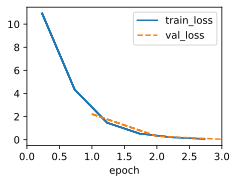

In [49]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2ltorch.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2ltorch.Trainer(max_epochs=3)
trainer.fit(model, data)

In [57]:
# torch.normal(10, 0.01, (10,1))
# torch.zeros((10,10))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [58]:
with torch.no_grad():
    print(f"error in estimating w : {data.w - model.w.reshape(data.w.shape)}" )
    print(f"error in estimating b : {data.b - model.b}")

error in estimating w : tensor([ 0.0868, -0.1833])
error in estimating b : tensor([0.1926])


### Question : What would happen if we were to initialize the weights to zero. Would the algorithm still work? What if we initialized the parameters with variance 1000 rather than 0.01?

error in estimating w : tensor([-0.0795,  0.0026])
error in estimating b : tensor([-0.0203])


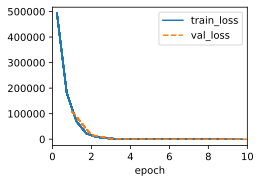

In [77]:
class LinearRegressionScratchExample(d2ltorch.Module):
    def __init__(self, num_inputs, lr, sigma=1000):
        super().__init__()
        self.save_hyperparameters()
        # self.w = torch.zeros((num_inputs, 1), requires_grad=True)
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True) # getting values form a Normal distribution with mu=0, sigma=0.01
        self.b = torch.zeros(1, requires_grad=True)

@d2ltorch.add_to_class(LinearRegressionScratchExample)
def forward(self, X):
    return torch.matmul(X, self.w) + self.b
@d2ltorch.add_to_class(LinearRegressionScratchExample)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)
@d2ltorch.add_to_class(LinearRegressionScratchExample)
def loss(self, y_hat, y):
    l = (y_hat-y)**2/2
    return l.mean()
modele = LinearRegressionScratchExample(2, lr=0.03)
data = d2ltorch.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2ltorch.Trainer(max_epochs=10)
trainer.fit(modele, data)

with torch.no_grad():
    print(f"error in estimating w : {data.w - modele.w.reshape(data.w.shape)}" )
    print(f"error in estimating b : {data.b - modele.b}")

In [79]:



print(model.b, data.b)
print(model.w, data.w)
print("+++++++")
print(modele.b, data.b)
print(modele.w, data.w)

tensor([4.0074], requires_grad=True) 4.2
tensor([[ 1.9132],
        [-3.2167]], requires_grad=True) tensor([ 2.0000, -3.4000])
+++++++
tensor([4.2203], requires_grad=True) 4.2
tensor([[ 2.0795],
        [-3.4026]], requires_grad=True) tensor([ 2.0000, -3.4000])


### Question : Assume that you are Georg Simon Ohm trying to come up with a model for resistance that relates voltage and current. Can you use automatic differentiation to learn the parameters of your model?

error in estimating w : tensor([-0.0300])
error in estimating b : 0


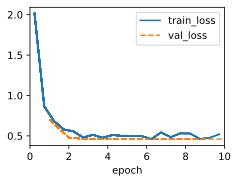

In [82]:
class LinearRegressionScratchExercise3(d2ltorch.Module):
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        # self.w = torch.zeros((num_inputs, 1), requires_grad=True)
        self.I = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True) # getting values form a Normal distribution with mu=0, sigma=0.01
        # self.b = torch.zeros(1, requires_grad=True)

@d2ltorch.add_to_class(LinearRegressionScratchExercise3)
def forward(self, X):
    return torch.matmul(X, self.I) # + self.b
@d2ltorch.add_to_class(LinearRegressionScratchExercise3)
def configure_optimizers(self):
    return SGD([self.I], self.lr)
@d2ltorch.add_to_class(LinearRegressionScratchExercise3)
def loss(self, y_hat, y):
    l = (y_hat-y)**2/2
    return l.mean()

model3 = LinearRegressionScratchExercise3(1, lr=0.03)
data = d2ltorch.SyntheticRegressionData(w=torch.tensor([2.0]), b=0, noise=1)
trainer = d2ltorch.Trainer(max_epochs=10)
trainer.fit(model3, data)

with torch.no_grad():
    print(f"error in estimating w : {data.w - model3.I.reshape(data.w.shape)}" )
    print(f"error in estimating b : {data.b}")

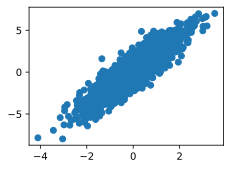

In [76]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3.5, 2.5))
plt.scatter(data.X, data.y)
plt.show()


### Question : Can you use Planck’s Law78 to determine the temperature of an object using spectral energy density? For reference, the spectral density 𝐵 of radiation emanating from a. Here 𝜆 is the wavelength, 𝑇 is the temperature, 𝑐 is the speed of light, h is Planck’s constant, and 𝑘 is the Boltzmann constant. You measure the energy for different wavelengths 𝜆 and you now need to fit the spectral density curve to Planck’s law.

In [86]:

def foo(lam, temp):
    c = 299792458
    h = 6.6260701e-34
    k = 1.380649e-23
    temp1 = 2*h*c**2/lam**5
    temp2 = h*c/(lam*k*temp)
    return temp1 / (torch.exp(temp2)-1)

class LinearRegressionScratchPlanck(d2ltorch.Module):
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        # self.w = torch.zeros((num_inputs, 1), requires_grad=True)
        # self.L = torch.normal(0, sigma, (1,1), requires_grad=True) # getting values form a Normal distribution with mu=0, sigma=0.01
        self.T = torch.normal(0, sigma, (num_inputs,1), requires_grad=True)
        # self.b = torch.zeros(1, requires_grad=True)



@d2ltorch.add_to_class(LinearRegressionScratchPlanck)
def forward(self, X):
    return foo(X, self.T) # + self.b
@d2ltorch.add_to_class(LinearRegressionScratchPlanck)
def configure_optimizers(self):
    return SGD([self.T], self.lr)
@d2ltorch.add_to_class(LinearRegressionScratchPlanck)
def loss(self, y_hat, y):
    l = (y_hat-y)**2/2
    return l.mean()

model3 = LinearRegressionScratchPlanck(2, lr=0.03)
data = d2ltorch.SyntheticRegressionData(w=torch.tensor([2.0]), b=1, noise=1)
trainer = d2ltorch.Trainer(max_epochs=10)
trainer.fit(model3, data)

with torch.no_grad():
    print(f"error in estimating w : {data.w - model3.T.reshape(data.w.shape)}" )
    print(f"error in estimating b : {data.b}")

RuntimeError: The size of tensor a (32) must match the size of tensor b (2) at non-singleton dimension 0